In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import torch
import torch.nn as nn

from random import shuffle
from scipy.stats import gamma, beta, nbinom, poisson
from scipy.special import gammaln, betaln
from torch.autograd import Variable
from utils import *

%matplotlib inline

mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['figure.figsize'] = (15, 5)

## Generate Poisson data, compare Poisson vs. negBin model

I will generate observed data from a Poisson distribution with a certain lambda. Then I will train a MDN to approximate the posterior over model indices. As models I use a Poisson with Gamma prior and a negative Binomial with Beta prior. 

### Controlling difficulty via over / under dispersion 
Overdispersion means that the dispersion predicted by the model is less than that present in the data. Here we can control the difficulty of distinguishing between the two models by changing the dispersion of the observed data and by making use of the fact that while in the Poisson model the mean equals the variance, in the NB model we have an additional DoF for the variance. 

Given that we want to start with a very simple case, we should choose the Gamma and Beta priors on the Poisson and the NB model such that they result in very different data models. 

In [17]:
sample_size = 1
n_samples = 10000

# set prior parameters 
# gamma prior shape and scale 
shape = 7.5
scale = 1.0
# create a frozen distribution object
gamma_prior = gamma(a=shape, scale=scale)

# beta prior shape and scale 
alp = 5. 
bet = 2.
# neg bin number of successes, fixed
r = 7.
beta_prior = beta(a=alp, b=bet)

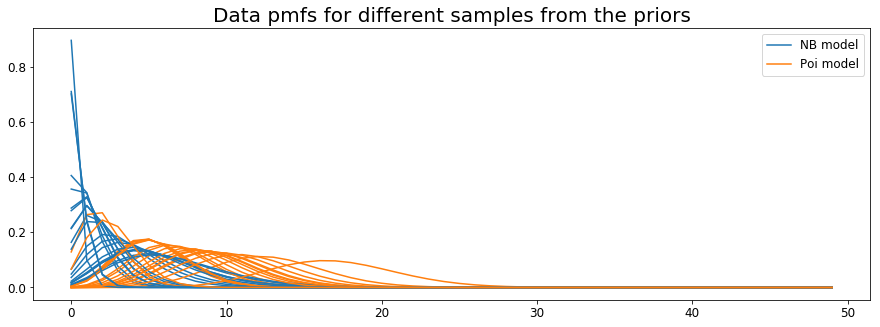

In [19]:
k = np.arange(50)

for i in range(20): 
    priorNB = nbinom.pmf(k, r, beta_prior.rvs())
    priorP = poisson.pmf(k, gamma_prior.rvs())

    plt.plot(k, priorNB, 'C0')
    plt.plot(k, priorP, 'C1')
    
plt.title('Data pmfs for different samples from the priors')
plt.legend(['NB model', 'Poi model']);

## Define functions for generating data from the two different models

In [20]:
def generate_dataset(n_samples, sample_size): 
    
    X = []
    thetas = []
    m = []

    # for every sample we want a triplet (m_i, theta, sx)
    for i in range(n_samples): 
        
        # sample model index 
        m_i = np.round(np.random.rand()).astype(int)
    
        # generate data from model 
        if m_i == 0: 
            theta, x = generate_poisson(sample_size, gamma_prior)
        elif m_i == 1: 
            theta, x = generate_negbin(sample_size, r, beta_prior)
            
        sx = calculate_stats(x)
            
        X.append(sx)
        thetas.append([theta])
        m.append([int(m_i)])
    
    return m, np.array(thetas), np.array(X)

## Define network for fitting the model posterior

In [21]:
class MDN_psi(nn.Module):
    
    def __init__(self, ndim_input=1, ndim_output=2, n_hidden=5, n_components=1):
        super(MDN_psi, self).__init__()
        self.fc_in = nn.Linear(ndim_input, n_hidden)
        self.tanh = nn.Tanh()
        self.m_out = nn.Linear(n_hidden, ndim_output)

    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        out_m = self.m_out(act)
        return out_m
    
def train_psi(X, Y, model, optim, lossfun, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]
    
    losses = []

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))            
            y_var = Variable(torch.LongTensor(y_batch)).view(n_minibatch)
            
            (out_act) = model(x_var)
            loss = lossfun(out_act, y_var)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            losses.append(loss.data[0])

        if (epoch + 1) % 100 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))
    
    return model, optim, losses

## Generate a large data set of triplets (m, theta, sx)

Then separate it into sets for model 1 and model 2 and train the phi networks separately. 

In [22]:
# generate data 
m, theta, X = generate_dataset(n_samples, sample_size)

# normalize 
X, norm = normalize(X)

In [23]:
n_inputs = 1
model = MDN_psi(ndim_input=n_inputs, n_hidden=5)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
lossfun = nn.CrossEntropyLoss()

model_psi, optim_psi, losses = train_psi(X, m, model, optim, lossfun, n_epochs=500, n_minibatch=100)

[epoch 0100] loss: 0.5664
[epoch 0200] loss: 0.5123
[epoch 0300] loss: 0.4919
[epoch 0400] loss: 0.5024
[epoch 0500] loss: 0.5431


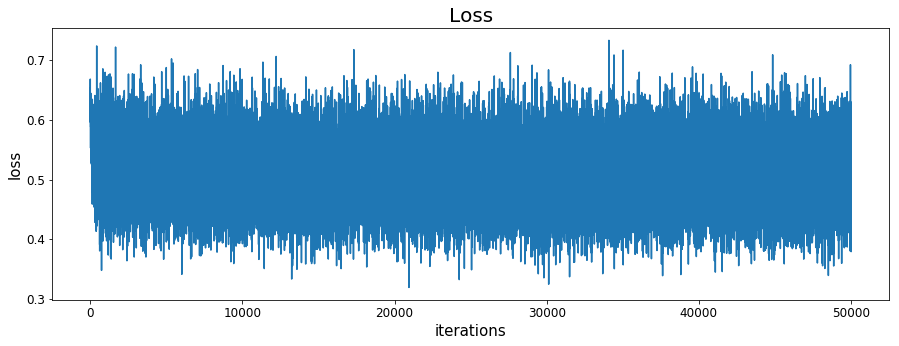

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss');

## Draw many samples and compare predicted to analytical Bayes Factor

In [25]:
bf_true = []
bf_predicted = []
model_indices = []
pred_mi = []

# gather summary stats
stats = []

# set the parameters of the underlying model as the means of the corresponding priors
poi_mean = gamma_prior.mean()
nb_psuccess = beta_prior.mean()

# flag for plotting sample distributions
plot = False

Ntest = 50
for i in range(Ntest): 
    
    # sample model index 
    m_i = np.round(np.random.rand()).astype(int)
    
    # draw samples from the model given by the model index 
    if m_i == 0: 
        samples = poisson.rvs(mu=poi_mean, size=sample_size)
    elif m_i == 1: 
        samples = nbinom.rvs(n=r, p=nb_psuccess, size=sample_size)
    
    if plot: 
        plt.subplot(1, 2, m_i + 1)
        plt.title('NB' if m_i else 'Poisson')
        plt.hist(samples, bins='auto', alpha=.5)
    
    # apply model for prediction
    stats_o = np.array(calculate_stats(samples)).reshape(1, n_inputs)
    stats_o, norm = normalize(stats_o, norm)
        
    stats.append(stats_o)
    
    X_var = Variable(torch.Tensor(stats_o))
    (out_act) = model(X_var)
    
    # in this vector, index 0 is Poi, index 1 is NB
    posterior_probs = nn.Softmax()(out_act).data.numpy()[0]
    # predict the model with the larger posterior 
    pred_mi.append(np.argmax(posterior_probs))
    
    # because we use a uniform prior the posterior ratio corresponds to the likelihood (evidence) ratio
    e0 = poisson_evidence(samples, shape, scale, sample_size, log=True)
    e1 = nbin_evidence(samples, alp, bet, sample_size, r, log=True)

    # calculate bf
    log_bftrue = e0 - e1
    bfpred = posterior_probs[0] / posterior_probs[1]
    
    # append to lists
    bf_predicted.append(np.log(bfpred))
    bf_true.append(log_bftrue)
    model_indices.append(m_i)
    
# true indices 
mi_true = np.array(model_indices)

# MAP estimate of model index 
mi_pred = np.array(pred_mi)

# predict m_i = 1 if log BF negaive, m_i = 0 if it is positive
mi_ana = (np.array(bf_true) < 0)

stats = np.array(stats).squeeze().reshape(Ntest, n_inputs)

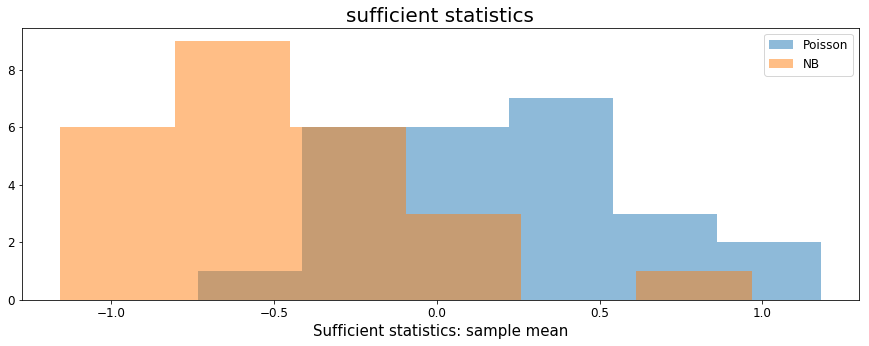

In [26]:
plt.title('sufficient statistics')
plt.hist(stats[mi_true.astype(int)==0, 0], bins='auto', label='Poisson', alpha=.5)
plt.hist(stats[mi_true.astype(int)==1, 0], bins='auto', label='NB', alpha=.5)
plt.xlabel('Sufficient statistics: sample mean')
plt.legend(); 

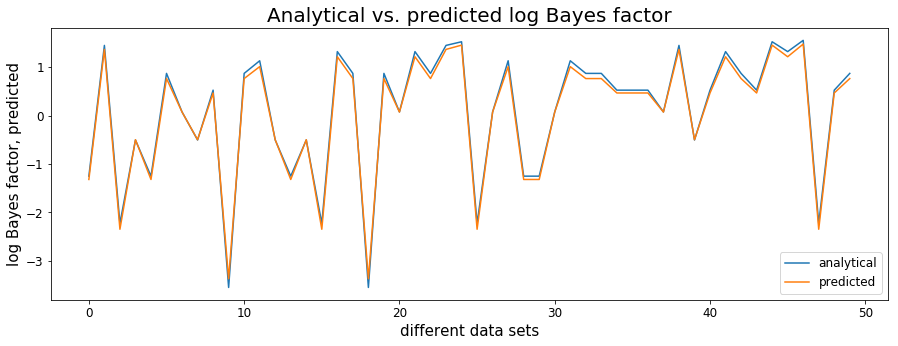

In [27]:
plt.figure(figsize=(15, 5))
plt.plot(bf_true, label='analytical', color='C0')
plt.ylabel('log Bayes factor, analytical')

#plt.twinx()
plt.plot(bf_predicted, label='predicted', color='C1')
plt.ylabel('log Bayes factor, predicted')
plt.xlabel('different data sets')
plt.title('Analytical vs. predicted log Bayes factor')

plt.legend(loc=4);

In [28]:
np.corrcoef(bf_true, bf_predicted)

array([[ 1.        ,  0.99908172],
       [ 0.99908172,  1.        ]])

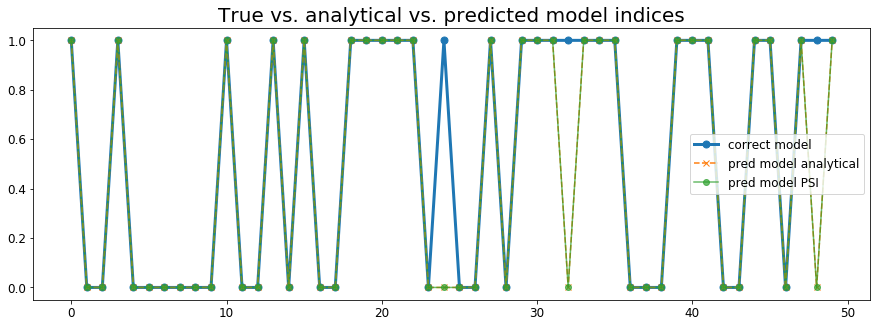

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(mi_true, 'o-', label='correct model', alpha=1., markersize=7, lw=3)
plt.plot(mi_ana, 'x--', label='pred model analytical', alpha=1.)
plt.plot(mi_pred, 'o-', label='pred model PSI', alpha=.7)
plt.title('True vs. analytical vs. predicted model indices')

plt.legend();